In [1]:
!pip install -q -U tf-hub-nightly

In [2]:
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# Pre-trained Model Load

In [3]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3, ))
])

# Image Load

In [5]:
grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)

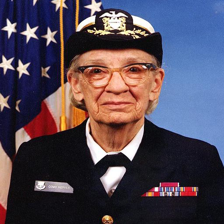

In [6]:
grace_hopper

In [7]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

# Model Prediction

In [8]:
# 모델에 입력하기 위한 형태로 만들어 준다. (B, W, H, C)
grace_hopper[np.newaxis, ...].shape

(1, 224, 224, 3)

In [9]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

(653, Text(0.5, 1.0, 'Prediction: Military Uniform'))

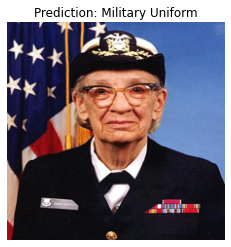

In [12]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_, plt.title("Prediction: " + predicted_class_name.title())

# Transfer Learning

## Dataset Load

In [13]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

### 데이터 로딩은 ```tf.keras.preprocessing.image.image.ImageDataGenerator```를 사용.
### ```ImageDataGenerator```의 ```rescale```인자를 사용해 normalize 해준다. (0~1 사이의 값을 갖도록 255로 나눠줌)

In [14]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


### 결과는 ```image_batch```, ```label_batch```를 같이 리턴한다. (dataset) 

In [15]:
for image_batch, label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [16]:
result_batch = classifier.predict(image_batch)
result_batch.shape  # batch_size = 32

(32, 1001)

In [17]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['mushroom', 'spider web', 'cardoon', 'conch', 'daisy', 'vase',
       'coil', 'cardoon', 'park bench', 'cabbage butterfly', 'goblet',
       'picket fence', 'daisy', 'bee', 'tricycle', 'stone wall', 'daisy',
       'barn spider', 'wool', 'pot', 'daisy', 'daisy', 'daisy', 'vase',
       'daisy', 'palace', 'clog', 'daisy', 'daisy', 'barn spider',
       'bell pepper', "yellow lady's slipper"], dtype='<U30')

# Accuracy check

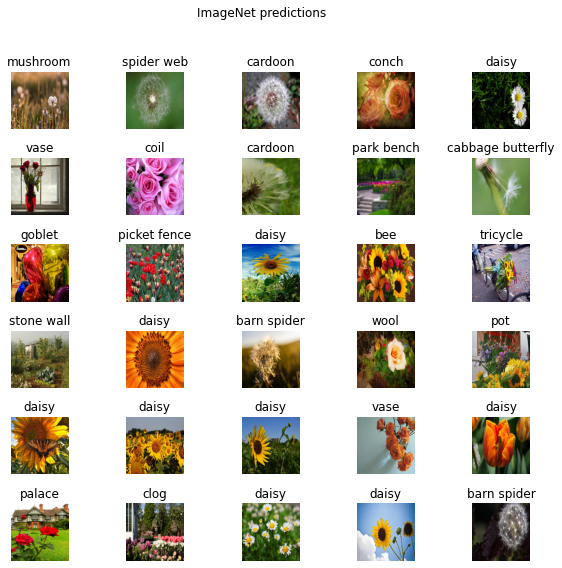

In [18]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')

_ = plt.suptitle("ImageNet predictions")

# 분류층이 없는 모델

In [19]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [20]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224, 224, 3))

In [21]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [22]:
# trainable=False 로 설정 시, 새로운 분류 계층만 변경시킬 수 있음.
feature_extractor_layer.trainable = False

In [23]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

# Model Training

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc']
)

- Callback으로 batch 당 정확도를 확인할 수 있다.

In [27]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

In [28]:
steps_per_epoch = np.ceil(image_data.samples / image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(
    image_data,
    epochs=2,
    steps_per_epoch=steps_per_epoch,
    callbacks=[batch_stats_callback]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/2
115/115 [==============================] - 27s 176ms/step - loss: 0.4300 - acc: 0.8438
Epoch 2/2
115/115 [==============================] - 14s 119ms/step - loss: 0.1667 - acc: 0.9688


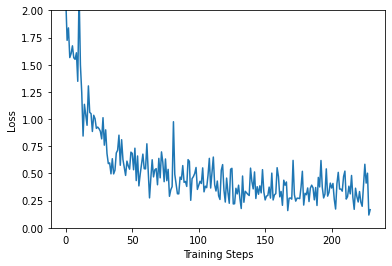

In [29]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0, 2])
plt.plot(batch_stats_callback.batch_losses)

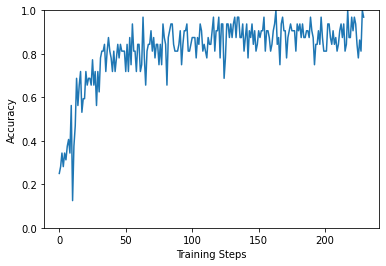

In [30]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0, 1])
plt.plot(batch_stats_callback.batch_acc)

In [33]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [34]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [38]:
predicted_id, len(predicted_id)  # batch_size=32

(array([1, 1, 1, 2, 0, 2, 2, 1, 4, 1, 4, 4, 3, 3, 4, 3, 3, 1, 2, 4, 3, 3,
        3, 2, 4, 2, 4, 0, 3, 1, 4, 4]), 32)

In [39]:
predicted_label_batch, len(predicted_label_batch)  # batch_size=32

(array(['Dandelion', 'Dandelion', 'Dandelion', 'Roses', 'Daisy', 'Roses',
        'Roses', 'Dandelion', 'Tulips', 'Dandelion', 'Tulips', 'Tulips',
        'Sunflowers', 'Sunflowers', 'Tulips', 'Sunflowers', 'Sunflowers',
        'Dandelion', 'Roses', 'Tulips', 'Sunflowers', 'Sunflowers',
        'Sunflowers', 'Roses', 'Tulips', 'Roses', 'Tulips', 'Daisy',
        'Sunflowers', 'Dandelion', 'Tulips', 'Tulips'], dtype='<U10'), 32)

In [35]:
label_id = np.argmax(label_batch, axis=-1)

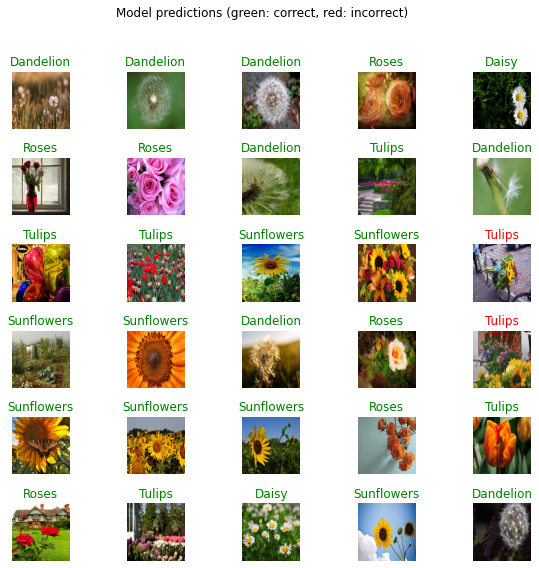

In [40]:
plt.figure(figsize=(10, 9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.imshow(image_batch[n])

    color = "green" if predicted_id[n] == label_id[n] else "red"  # 예측이 맞으면 green 틀린 경우 red

    plt.title(predicted_label_batch[n].title(), color=color)
    plt.axis('off')

_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

# Model Save

In [41]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1655873784/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1655873784/assets


'/tmp/saved_models/1655873784'

In [42]:
reloaded = tf.keras.models.load_model(export_path)

In [43]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [45]:
abs(reloaded_result_batch - result_batch).max()

0.0

- 저장된 모델은 추후에 추론하거나 TFLite 나 TFjs로 변환가능